# CECS6001 Assignment Four: Present Data

### Glen Berman and Charlotte Bradley, March 2019

This week's Fundamentals assignment was to select some data from the [ACT Government Open Data Portal](https://www.data.act.gov.au/) and prepare one or more data visualisations of it in pairs. We decided to use this as an opportunity to practice and extend the python skills we have been learning in the Lab. We are both enthusiastic Python beginners.

Initially, the plan was to submit only our visualisation. However, we wanted to share this Jupyter notebook as evidence of our learning and as a way of seeing 'under the hood' of our visualisation. This helps to draw out the problems of working with data, and prise open rather than smooth over the cracks in our visualisation.

In reflecting on sharing the 'under the hood' aspects of our visualisation, we've also been able to experience firsthand the ways that the expectation of transparency can alter how analysts present data. Knowing that we'd be showing our workings encouraged us to be cautious in our data extrapolation and analysis, and to be particularly mindful of annotating our visualisation methodology. This experience leads us to ask: when data visualisations are used in journalism, should backend transparency become the editorial standard?
> We have noted specific challenges encountered at each stage in a block quote like this.




### The Plan

Initially, we wanted to compare Canberra's public infrastructure (public toilets, furniture, bbqs etc.) with other capital cities, like London and New Delhi. We wanted to give Canberran's a new way of looking at and appreciating their city. However, we found it very difficult to find like data for other capital cities.

> - Availability of data
> - Uniformity of data
> - Currency of data

Instead of using *comparison*, we decided to use *context* - or lack of context - to give Canberran's a different view on their city. The new plan was to display different elements of public infrastructure by 'division' (or suburb) in layers - asking the viewer to guess location by the public infrastructure it contains. These visualisations would be presented as playing cards that could be used in a community engagement setting. We chose to focus on Aranda, Braddon, Deakin and Kambah, which represents a spread of suburbs from north to south, inner to outer.

In [2]:
#import the required python packages for this notebook

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pyproj
import descartes
import requests
import os
import rtree

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Read in the data we are interested in.

act_toilet_data = pd.read_csv('Public_Toilets_in_the_ACT.csv')
#Original source: https://www.data.act.gov.au/Infrastructure-and-Utilities/Public-Toilets-in-the-ACT/3tyf-txjn
act_publicschool_data = pd.read_csv('Schools_in_the_ACT.csv')
#Original source: https://www.data.act.gov.au/Education/ACT-School-Locations-2017-archived/q8rt-q8cy
act_furniture_data = pd.read_csv('Public_Furniture_in_the_ACT.csv')
#Original source: https://www.data.act.gov.au/Infrastructure-and-Utilities/Public-Furniture-in-the-ACT/ch39-bukk
act_bbq_data = pd.read_csv('Public_Barbeques_in_the_ACT.csv')
#Original source: https://www.data.act.gov.au/Infrastructure-and-Utilities/Public-Barbeques-in-the-ACT/n3b4-mm52

#Tidy up the column names, where needed.

act_toilet_data = act_toilet_data.rename(index=str, columns={
    "ASSET_ID": "id",
    "DIVISION_NAME": "area",
    "LOCATION_DESCRIPTION": "location",
    "TOILET_TYPE_TEXT": "type",
    "Location": "coordinates",
    "LATITUDE": "lat",
    "LONGITUDE": "lon"})

act_furniture_data = act_furniture_data.rename(index=str, columns={
    "ASSET_ID": "id",
    "DIVISION_NAME": "area",
    "LOCATION_NAME": "location",
    "FEATURE_TYPE": "type",
    "Location 1": "coordinates",
    "LATITUDE": "lat",
    "LONGITUDE": "lon"})

act_bbq_data = act_bbq_data.rename(index=str, columns={
    "ASSET_ID": "id",
    "DIVISION_NAME": "area",
    "LOCATION_NAME": "location",
    "FEATURE_TYPE": "type",
    "Location 1": "coordinates",
    "LATITUDE": "lat",
    "LONGITUDE": "lon"})

We were disappointed to find that the toilet data did not contain information about accessibility, which would have been useful to include for a community audience.

We found that latitude and longitude was missing for some of the schools, and had to fill in that information for schools in the suburbs we were interested in.
> - Gaps in the data - not included at all (accessibility)
> - Missing data  - blank fields (longtitude, latitude)
> - Messy or unusually formatted data

In [4]:
#Pull the coordinates out into a list of tuples for conversion. Be warned this will take a while to run.
#from longtitude/latitude to GDA94 / MGA zone 55 projection

zipped_toilet_coordinates = list(zip(act_toilet_data['lon'], act_toilet_data['lat']))
zipped_school_coordinates = list(zip(act_publicschool_data['lon'], act_publicschool_data['lat']))
zipped_furniture_coordinates = list(zip(act_furniture_data['lon'], act_furniture_data['lat']))
zipped_bbq_coordinates = list(zip(act_bbq_data['lon'], act_bbq_data['lat']))

#Convert into a new list of tuples

epsg4326 = pyproj.Proj(init='epsg:4326')
epsg28355 = pyproj.Proj(init='epsg:28355')

toilet_coordinates = []
for x, y in zipped_toilet_coordinates:
    toilet_coordinates.append(pyproj.transform(epsg4326,epsg28355,x,y))
    
bbq_coordinates = []
for x, y in zipped_bbq_coordinates:
    bbq_coordinates.append(pyproj.transform(epsg4326,epsg28355,x,y))
    
furniture_coordinates = []
for x, y in zipped_furniture_coordinates:
    furniture_coordinates.append(pyproj.transform(epsg4326,epsg28355,x,y))
    
school_coordinates = []
for x, y in zipped_school_coordinates:
    school_coordinates.append(pyproj.transform(epsg4326,epsg28355,x,y))

In order to filter and plot public infrastructure by division onto a map of Canberra, we needed to convert the spatial reference data in these files from longtitude/latitude to MGA Zone 55, which is the format used in the shapefiles provided in the ACT Open Data Portal. A shapefile is a ['geospatial data format'](https://en.wikipedia.org/wiki/Shapefile) that describes a space in points, polylines and polygons.

This was a really hard problem for us to solve, but Charlotte was able to crack it! It wasn't immediately obvious to us what projection was used in the shapefiles. Once we identified it as MGA Zone 55, it took some time to work out how to do the translation.

> - Differing data formats
> - Missing or obscure metadata

In [5]:
#create Coordinate Reference System(crs) variable for GeoDataFrame.
#This tells Python how the coordinates in our data are related to places on the Earth.

crs = {'init': 'epsg:28355'}

#create geometry variable for GeoDataFrame

toilet_geometry = [Point(x, y) for x, y in toilet_coordinates]
bbq_geometry = [Point(x, y) for x, y in bbq_coordinates]
furniture_geometry = [Point(x, y) for x, y in furniture_coordinates]
school_geometry = [Point(x, y) for x, y in school_coordinates]

#create GeoDataFrame

act_toilets = gpd.GeoDataFrame(act_toilet_data, crs=crs, geometry=toilet_geometry)
act_bbqs = gpd.GeoDataFrame(act_bbq_data, crs=crs, geometry=bbq_geometry)
act_furniture = gpd.GeoDataFrame(act_furniture_data, crs=crs, geometry=furniture_geometry)
act_schools = gpd.GeoDataFrame(act_publicschool_data, crs=crs, geometry=school_geometry)


Even before starting to think about analysis or visualisation we have manipulated the data significantly. So far we have relabelled data, filled in missing data, learned new concepts to interpret data, created a new reference for data (e.g. "zipped_toilet_data"), converted that data from one geospatial 'language' to another (e.g. "toilet_geometry"), and recast data in a new format for interpretation (from a standard Pandas DataFrame to a Geopandas GeoDataFrame).



In [6]:
#read in the ACT shapemap files for our visualisation

act_divisions = gpd.read_file('ACT_data/ACT_division.shp')
act_roads = gpd.read_file('ACT_data/ACT_Road_Centrelines.shp')

#create the Canberra slices
canberra_divisions = act_divisions.cx[682000:702000,6070000:6110000]
canberra_roads = act_roads.cx[682000:702000,6070000:6110000]

canberra_furniture= act_furniture.cx[682000:702000,6070000:6110000]
canberra_toilet = act_toilets.cx[682000:702000,6070000:6110000]
canberra_bbq = act_bbqs.cx[682000:702000,6070000:6110000]
canberra_publicschool = act_schools.cx[682000:702000,6070000:6110000]

#create the 4 divisions we're focusing on

kambah = gpd.GeoDataFrame(act_divisions[act_divisions['DIVISION_N'] == "KAMBAH"], crs=crs)
aranda = gpd.GeoDataFrame(act_divisions[act_divisions['DIVISION_N'] == "ARANDA"], crs=crs)
deakin = gpd.GeoDataFrame(act_divisions[act_divisions['DIVISION_N'] == "DEAKIN"], crs=crs)
braddon = gpd.GeoDataFrame(act_divisions[act_divisions['DIVISION_N'] == "BRADDON"], crs=crs)

#set the geometry and crs for the new division data frames

kambah = gpd.GeoDataFrame(kambah, crs=crs, geometry=kambah['geometry'])
aranda = gpd.GeoDataFrame(aranda, crs=crs, geometry=aranda['geometry'])
deakin = gpd.GeoDataFrame(deakin, crs=crs, geometry=deakin['geometry'])
braddon = gpd.GeoDataFrame(braddon, crs=crs, geometry=braddon['geometry'])


Up until this point, we have been working with whole datasets. In the cells above and below, we have started to filter those datasets down to the spaces we are interested in.
> - filtering data, which is to say *selecting* and *removing* data

In [7]:
#for each of our districts, gather relevant data.
#In each case, we are comparing the public infrastructure data with the relevant district data.
#We are using gpd.sjoin to look for infrastructure point geometry that falls within the division polygon geometry.

kambah_toilets = gpd.sjoin(act_toilets, kambah, op='within')
kambah_bbqs = gpd.sjoin(act_bbqs, kambah, op='within')
kambah_furniture = gpd.sjoin(act_furniture, kambah, op='within')
kambah_schools = gpd.sjoin(act_schools, kambah, op='within')

aranda_toilets = gpd.sjoin(act_toilets, aranda, op='within')
aranda_bbqs = gpd.sjoin(act_bbqs, aranda, op='within')
aranda_furniture = gpd.sjoin(act_furniture, aranda, op='within')
aranda_schools = gpd.sjoin(act_schools, aranda, op='within')

deakin_toilets = gpd.sjoin(act_toilets, deakin, op='within')
deakin_bbqs = gpd.sjoin(act_bbqs, deakin, op='within')
deakin_furniture = gpd.sjoin(act_furniture, deakin, op='within')
deakin_schools = gpd.sjoin(act_schools, deakin, op='within')

braddon_toilets = gpd.sjoin(act_toilets, braddon, op='within')
braddon_bbqs = gpd.sjoin(act_bbqs, braddon, op='within')
braddon_furniture = gpd.sjoin(act_furniture, braddon, op='within')
braddon_schools = gpd.sjoin(act_schools, braddon, op='within')

In [13]:
#Set the background colours, based on populuation size.
#Color range: population of 0 = #FFFFFF; population of 18,000 = #5da262
# 5% darker for every 2000 people.
#For population source see: 
#https://www.data.act.gov.au/People-and-Society/ACT-Population-Projections-by-Suburb-2015-2020-/kci6-ugxa/data

kambah_color = "#7CB480"
aranda_color = "#E8F2E9"
braddon_color = "#C6DEC8"
deakin_color = "#E7F1E7"

<font color="#7CB480">**KAMBAH**</font>

<font color="#E8F2E9">**ARANDA**</font>

<font color="#C6DEC8">**BRADDON**</font>

<font color="#E7F1E7">**DEAKIN**</font>


We initially chose different colours from each other for displaying our data. Charlotte had failed to account for colourblind viewers, like Glen. The final colours have been chosen with that in mind.
> - accessibility considerations in displaying data

In [14]:
#Set the colors for the data we are plotting.

furniture_color = "#929084" 
bbq_color = "#E5323B"
school_color = "#FFC857"
toilets_color = "#A997DF"

<font color="#929084">**FURNITURE**</font>

<font color="#E5323B">**BBQS**</font>

<font color="#FFC857">**SCHOOLS**</font>

<font color="#A997DF">**TOILETS**</font>


In [15]:
#Load in an external file with populations, number of schools, etc, for each division, 
#and suggested proportions for marker size.

markers = pd.read_csv('markersize_calculations.csv')

#tidy up the file

markers = markers.rename(index=str, columns={
    "BBQ markersize": "bbq_size",
    "Schoools markersize": "school_size",
    "Toilet markersize": "toilet_size"})

markers.head()

,Division,Population,Schools,school_size,Toilets,toilet_size,BBQs,bbq_size,School min,School max,Toilet min,Toilet max,BBQ min,BBQ max
0,Braddon,6365,2,2546.00,1,836.500000,2,288.250000,900,2700,300,900,100,300
1,Deakin,2686,4,537.20,2,334.300000,0,0.000000,900,2700,300,900,100,300
2,Kambah,14569,5,2331.04,3,685.633333,7,178.128571,900,2700,300,900,100,300
3,Aranda,2505,2,1002.00,0,0.000000,0,0.000000,900,2700,300,900,100,300


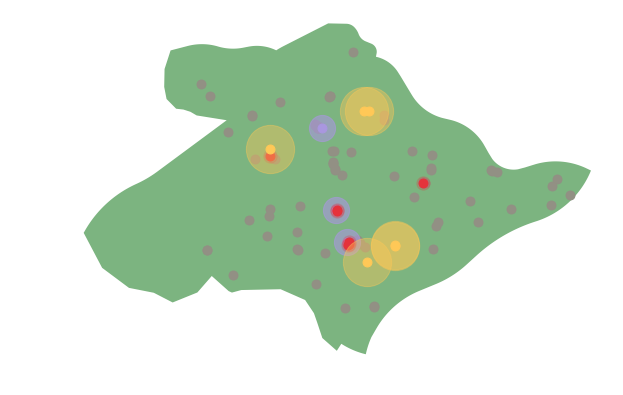

In [16]:
#Kambah visualisation

fig,ax = plt.subplots(figsize=(10,10))
kambah.plot(ax=ax, color=kambah_color, alpha=1)

#Plot dots and circles around dots, varying by population:service size.
kambah_furniture.plot(ax=ax, color=furniture_color, markersize=80, alpha=1)
kambah_toilets.plot(ax=ax, color=toilets_color, markersize=markers.toilet_size[markers['Division'] == "Kambah"], alpha=0.6)
kambah_toilets.plot(ax=ax, color=toilets_color, markersize=80, alpha=1)
kambah_bbqs.plot(ax=ax, color=bbq_color, markersize=markers.bbq_size[markers['Division'] == "Kambah"], alpha=0.2)
kambah_bbqs.plot(ax=ax, color=bbq_color, markersize=80, alpha=1)
kambah_schools.plot(ax=ax, color=school_color, markersize=markers.school_size[markers['Division'] == "Kambah"], alpha=0.4)
kambah_schools.plot(ax=ax, color=school_color, markersize=80, alpha=1)

#Styling.
ax.set_axis_off()

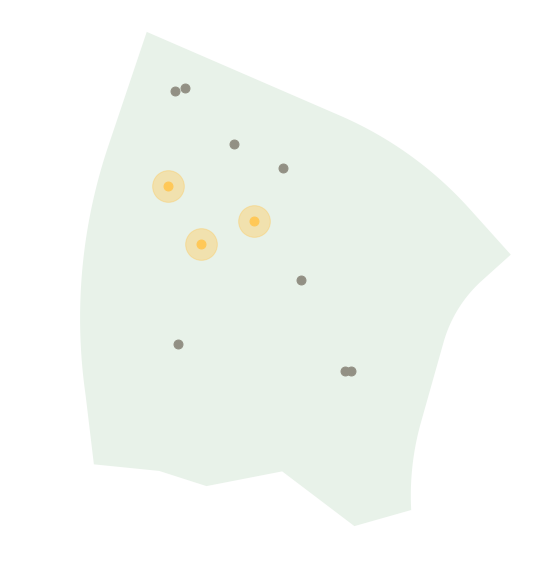

In [18]:
#Aranda visualisation
#Note that we have commented out toilets and bbqs as there are no data points for these items

fig,ax = plt.subplots(figsize=(10,10))
aranda.plot(ax=ax, color=aranda_color, alpha=1)

#Plot dots and circles around dots, varying by population:service size.
aranda_furniture.plot(ax=ax, color=furniture_color, markersize=80, alpha=1)
#aranda_toilets.plot(ax=ax, color=toilets_color, markersize=markers.toilet_size[markers['Division'] == "Aranda"], alpha=0.6)
#aranda_toilets.plot(ax=ax, color=toilets_color, markersize=80, alpha=1)
#aranda_bbqs.plot(ax=ax, color=bbq_color, markersize=markers.bbq_size[markers['Division'] == "Aranda"], alpha=0.2)
#aranda_bbqs.plot(ax=ax, color=bbq_color, markersize=80, alpha=1)
aranda_schools.plot(ax=ax, color=school_color, markersize=markers.school_size[markers['Division'] == "Aranda"], alpha=0.4)
aranda_schools.plot(ax=ax, color=school_color, markersize=80, alpha=1)

#Styling.
ax.set_axis_off()

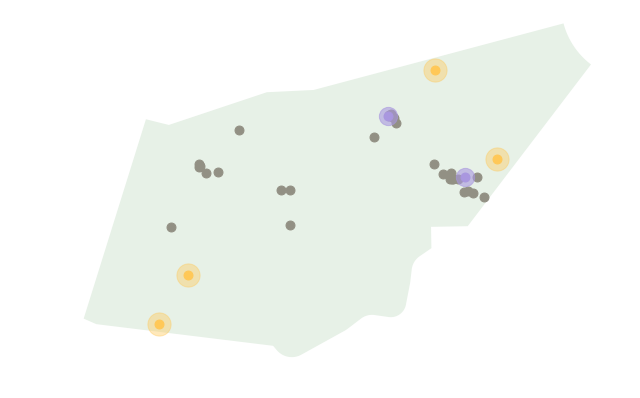

In [20]:
#Deakin visualisation

fig,ax = plt.subplots(figsize=(10,10))
deakin.plot(ax=ax, color=deakin_color, alpha=1)

#Plot dots and circles around dots, varying by population:service size.
deakin_furniture.plot(ax=ax, color=furniture_color, markersize=80, alpha=1)
deakin_toilets.plot(ax=ax, color=toilets_color, markersize=markers.toilet_size[markers['Division'] == "Deakin"], alpha=0.6)
deakin_toilets.plot(ax=ax, color=toilets_color, markersize=80, alpha=1)
#deakin_bbqs.plot(ax=ax, color=bbq_color, markersize=markers.bbq_size[markers['Division'] == "Deakin"], alpha=0.2)
#deakin_bbqs.plot(ax=ax, color=bbq_color, markersize=80, alpha=1)
deakin_schools.plot(ax=ax, color=school_color, markersize=markers.school_size[markers['Division'] == "Deakin"], alpha=0.4)
deakin_schools.plot(ax=ax, color=school_color, markersize=80, alpha=1)

#Styling.
ax.set_axis_off()

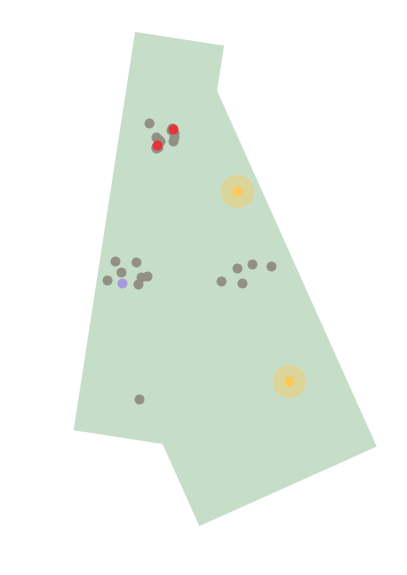

In [21]:
#Braddon visualisation

fig,ax = plt.subplots(figsize=(10,10))
braddon.plot(ax=ax, color=braddon_color, alpha=1)

#Plot dots and circles around dots, varying by population:service size.
braddon_furniture.plot(ax=ax, color=furniture_color, markersize=80, alpha=1),
braddon_toilets.plot(ax=ax, color=toilets_color, markersize=markers.toilet_size[markers['Division'] == "Aranda"], alpha=0.6),
braddon_toilets.plot(ax=ax, color=toilets_color, markersize=80, alpha=1),
braddon_bbqs.plot(ax=ax, color=bbq_color, markersize=markers.bbq_size[markers['Division'] == "Aranda"], alpha=0.2),
braddon_bbqs.plot(ax=ax, color=bbq_color, markersize=80, alpha=1),
braddon_schools.plot(ax=ax, color=school_color, markersize=markers.school_size[markers['Division'] == "Aranda"], alpha=0.4),
braddon_schools.plot(ax=ax, color=school_color, markersize=80, alpha=1) 

#Styling.
ax.set_axis_off()

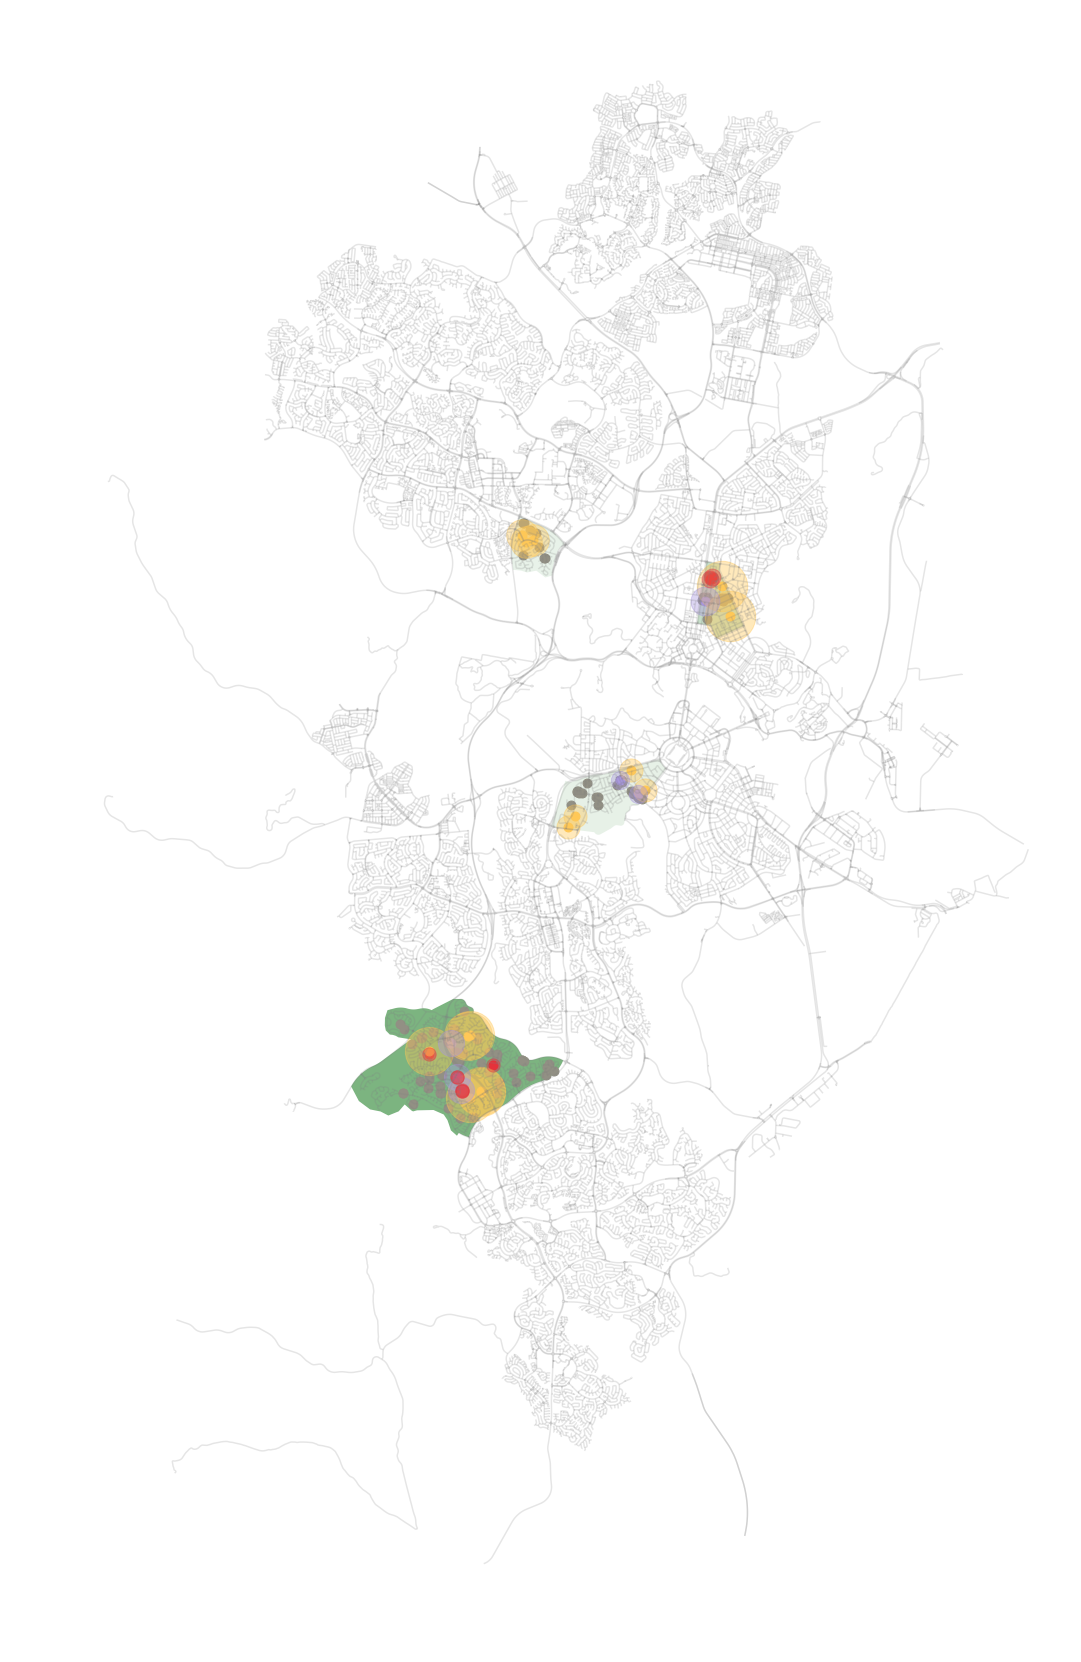

In [25]:
#Everything visualised on a map

fig,ax = plt.subplots(figsize=(30,30))
braddon.plot(ax=ax, color=braddon_color, alpha=1)
deakin.plot(ax=ax, color=deakin_color, alpha=1)
aranda.plot(ax=ax, color=aranda_color, alpha=1)
kambah.plot(ax=ax, color=kambah_color, alpha=1)
canberra_roads.plot(ax=ax, color='grey',alpha=0.2)

#Plot dots
braddon_furniture.plot(ax=ax, color=furniture_color, markersize=80, alpha=1)
braddon_bbqs.plot(ax=ax, color=bbq_color, markersize=80, alpha=1)
braddon_toilets.plot(ax=ax, color=toilets_color, markersize=80, alpha=1)
braddon_schools.plot(ax=ax, color=school_color, markersize=80, alpha=1)

deakin_furniture.plot(ax=ax, color=furniture_color, markersize=80, alpha=1)
#deakin_bbqs.plot(ax=ax, color=bbq_color, markersize=80, alpha=1)
deakin_toilets.plot(ax=ax, color=toilets_color, markersize=80, alpha=1)
deakin_schools.plot(ax=ax, color=school_color, markersize=80, alpha=1)

aranda_furniture.plot(ax=ax, color=furniture_color, markersize=80, alpha=1)
#aranda_bbqs.plot(ax=ax, color=bbq_color, markersize=80, alpha=1)
#aranda_toilets.plot(ax=ax, color=toilets_color, markersize=80, alpha=1)
aranda_schools.plot(ax=ax, color=school_color, markersize=80, alpha=1)

kambah_furniture.plot(ax=ax, color=furniture_color, markersize=80, alpha=1)
kambah_bbqs.plot(ax=ax, color=bbq_color, markersize=80, alpha=1)
kambah_toilets.plot(ax=ax, color=toilets_color, markersize=80, alpha=1)
kambah_schools.plot(ax=ax, color=school_color, markersize=80, alpha=1)

#Plot circles around dots, varying by population:service size.
braddon_schools.plot(ax=ax, color=school_color, markersize=markers.school_size[markers['Division'] == "Braddon"], alpha=0.4)
braddon_toilets.plot(ax=ax, color=toilets_color, markersize=markers.toilet_size[markers['Division'] == "Braddon"], alpha=0.4)
braddon_bbqs.plot(ax=ax, color=bbq_color, markersize=markers.bbq_size[markers['Division'] == "Braddon"], alpha=0.4)

deakin_schools.plot(ax=ax, color=school_color, markersize=markers.school_size[markers['Division'] == "Deakin"], alpha=0.4)
deakin_toilets.plot(ax=ax, color=toilets_color, markersize=markers.toilet_size[markers['Division'] == "Deakin"], alpha=0.4)
#deakin_bbqs.plot(ax=ax, color=bbq_color, markersize=markers.bbq_size[markers['Division'] == "Deakin"], alpha=0.4)

aranda_schools.plot(ax=ax, color=school_color, markersize=markers.school_size[markers['Division'] == "Aranda"], alpha=0.4)
#aranda_toilets.plot(ax=ax, color=toilets_color, markersize=markers.toilet_size[markers['Division'] == "Aranda"], alpha=0.4)
#aranda_bbqs.plot(ax=ax, color=bbq_color, markersize=markers.bbq_size[markers['Division'] == "Aranda"], alpha=0.4)

kambah_schools.plot(ax=ax, color=school_color, markersize=markers.school_size[markers['Division'] == "Kambah"], alpha=0.4)
kambah_toilets.plot(ax=ax, color=toilets_color, markersize=markers.toilet_size[markers['Division'] == "Kambah"], alpha=0.4)
kambah_bbqs.plot(ax=ax, color=bbq_color, markersize=markers.bbq_size[markers['Division'] == "Kambah"], alpha=0.4)

#Styling
ax.set_axis_off()

#Save a high res .png
plt.savefig('visualisation.png')



### Conclusion
